In [1]:
!pip install geopandas
!pip install kaleido
!pip install chart_studio
import pandas as pd
import geopandas as gp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

### Important links for the project

* http://www.der.sp.gov.br/WebSite/MalhaRodoviaria/VolumeDiario.aspx - dados de volume de tráfego na malha rodoaviária do estado de São Paulo
* http://servicos.dnit.gov.br/dadospnct/Modelagem - dados de volume de tráfego na malha rodoviária Brasil
* https://www.ibge.gov.br/geociencias/organizacao-do-territorio/15774-malhas.html?=&t=downloads - dados municípios

## Building the network

In [2]:
G = nx.Graph()
muniDf = gp.read_file("BR_Municipios_2020/BR_Municipios_2020.shp")
muniDf["MUN_UF"] = muniDf["NM_MUN"] + " (" + muniDf["SIGLA_UF"] + ")"
muniDf.head(2)

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,MUN_UF
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...",Alta Floresta D'Oeste (RO)
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736...",Ariquemes (RO)


Creating 2 undirected networke where each node is a city that is linked to its neighboors.
* G = network roads
* H = network roads + airways 

In [3]:
for index, row in muniDf.iterrows():
    neighbors = muniDf[muniDf.geometry.touches(row["geometry"])].MUN_UF.tolist()
    neighbors = [
        (row.MUN_UF, name, {"aereo": "nao"}) for name in neighbors if row.MUN_UF != name
    ]
    G.add_edges_from(neighbors)
    nx.set_node_attributes(
        G,
        {row.MUN_UF: {"long": row.geometry.centroid.x, "lat": row.geometry.centroid.y}},
    )

print("Done!")

Done!


In [4]:
aeroDf = pd.read_excel("/Users/ana/Downloads/airport_bz.xlsx")
aeroDf.head(2)

,A1,A2
0,Óbidos (PA),Itaituba (PA)
1,Óbidos (PA),Oriximiná (PA)


In [5]:
H = G.copy()
for index, row in aeroDf.iterrows():
    H.add_edge(row.A1, row.A2, aereo="sim")
print("Done!")

Done!


Adding node attributes: 
* population + population class
* region
* capital

In [6]:
popDf = pd.read_excel("MUNIC_2019.xlsx")
popDf.head(2)

,CodMun,REGIAO,COD UF,UF,NOME MUNIC,POP EST,CLASSE POP
0,1100015,1 - Norte,11,RO,Alta Floresta D'Oeste (RO),22945,4 - 20001 até 50000
1,1100023,1 - Norte,11,RO,Ariquemes (RO),107863,6 - 100001 até 500000


In [7]:
for index, row in popDf.iterrows():
    nx.set_node_attributes(
        G,
        {row["NOME MUNIC"]: {"population": row["POP EST"], "class": row["CLASSE POP"]}},
    )
    nx.set_node_attributes(
        H,
        {row["NOME MUNIC"]: {"population": row["POP EST"], "class": row["CLASSE POP"]}},
    )

In [8]:
node_dict = {
    "Tabocão (TO)": 2423,
    "Ereré (CE)": 7225,
    "Olho d'Água do Borges (RN)": 4244,
    "Campo Grande (RN)": 9768,
    "São Vicente Férrer (PE)": 18085,
    "Amparo do São Francisco (SE)": 2380,
    "Gracho Cardoso (SE)": 5824,
    "Araçás (BA)": 12208,
    "Santa Terezinha (BA)": 10464,
    "Muquém do São Francisco (BA)": 11417,
    "Iuiu (BA)": 11016,
    "Dona Euzébia (MG)": 6619,
    "São Tomé das Letras (MG)": 7120,
    "Passa Vinte (MG)": 2031,
    "Atílio Vivácqua (ES)": 12105,
    "Itaoca (SP)": 3330,
    "Biritiba Mirim (SP)": 32936,
    "Florínea (SP)": 2653,
    "São Luiz do Paraitinga (SP)": 10690,
    "Lauro Müller (SC)": 15313,
    "Grão-Pará (SC)": 6595,
    "São Cristóvão do Sul (SC)": 5598,
}
nx.set_node_attributes(G, node_dict, "population")
nx.set_node_attributes(H, node_dict, "population")
node_dict = {
    "Tabocão (TO)": "2 - 5001 até 10000",
    "Ereré (CE)": "2 - 5001 até 10000",
    "Olho d'Água do Borges (RN)": "2 - 5001 até 10000",
    "Campo Grande (RN)": "2 - 5001 até 10000",
    "São Vicente Férrer (PE)": "3 - 10001 até 20000",
    "Amparo do São Francisco (SE)": "2 - 5001 até 10000",
    "Gracho Cardoso (SE)": "2 - 5001 até 10000",
    "Araçás (BA)": "3 - 10001 até 20000",
    "Santa Terezinha (BA)": "3 - 10001 até 20000",
    "Muquém do São Francisco (BA)": "3 - 10001 até 20000",
    "Iuiu (BA)": "3 - 10001 até 20000",
    "Dona Euzébia (MG)": "2 - 5001 até 10000",
    "São Tomé das Letras (MG)": "2 - 5001 até 10000",
    "Passa Vinte (MG)": "2 - 5001 até 10000",
    "Atílio Vivácqua (ES)": "3 - 10001 até 20000",
    "Itaoca (SP)": "2 - 5001 até 10000",
    "Biritiba Mirim (SP)": "4 - 20001 até 50000",
    "Florínea (SP)": "2 - 5001 até 10000",
    "São Luiz do Paraitinga (SP)": "3 - 10001 até 20000",
    "Lauro Müller (SC)": "3 - 10001 até 20000",
    "Grão-Pará (SC)": "2 - 5001 até 10000",
    "São Cristóvão do Sul (SC)": "2 - 5001 até 10000",
}
nx.set_node_attributes(G, node_dict, "class")
nx.set_node_attributes(H, node_dict, "class")
nx.set_node_attributes(H, {"Fernando de Noronha (PE)": -3.853808}, "lat")
nx.set_node_attributes(H, {"Fernando de Noronha (PE)": -32.423786}, "long")

In [9]:
for node in H.nodes():
    if node[-3:][:2] in ["PR", "SC", "RS"]:
        nx.set_node_attributes(H, {node: "Sul"}, "region")
    elif node[-3:][:2] in ["SP", "MG", "RJ", "ES"]:
        nx.set_node_attributes(H, {node: "Sudeste"}, "region")
    elif node[-3:][:2] in ["MT", "MS", "GO", "DF"]:
        nx.set_node_attributes(H, {node: "CentroOeste"}, "region")
    elif node[-3:][:2] in ["BA", "PI", "MA", "SE", "AL", "PE", "PB", "RN", "CE"]:
        nx.set_node_attributes(H, {node: "Nordeste"}, "region")
    elif node[-3:][:2] in ["AC", "RO", "AM", "RR", "PA", "AP", "TO"]:
        nx.set_node_attributes(H, {node: "Norte"}, "region")

    if node in [
        "Manaus (AM)",
        "Boa Vista (RR)",
        "Macapá (AP)",
        "Belém (PA)",
        "Palmas (TO)",
        "Porto Velho (RO)",
        "Rio Branco (AC)",
        "São Luís (MA)",
        "Fortaleza (CE)",
        "Natal (RN)",
        "Recife (PE)",
        "João Pessoa (PB)",
        "Aracaju (SE)",
        "Maceió (AL)",
        "Salvador (BA)",
        "Cuiabá (MT)",
        "Campo Grande (MS)",
        "Goiânia (GO)",
        "São Paulo (SP)",
        "Rio de Janeiro (RJ)",
        "Vitória (ES)",
        "Belo Horizonte (MG)",
        "Curitiba (PR)",
        "Porto Alegre (RS)",
        "Florianópolis (SC)",
    ]:
        nx.set_node_attributes(H, {node: "sim"}, "capital")
    else:
        nx.set_node_attributes(H, {node: "nao"}, "capital")

for node in G.nodes():
    if node[-3:][:2] in ["PR", "SC", "RS"]:
        nx.set_node_attributes(G, {node: "Sul"}, "region")
    elif node[-3:][:2] in ["SP", "MG", "RJ", "ES"]:
        nx.set_node_attributes(G, {node: "Sudeste"}, "region")
    elif node[-3:][:2] in ["MT", "MS", "GO"]:
        nx.set_node_attributes(G, {node: "CentroOeste"}, "region")
    elif node[-3:][:2] in ["BA", "PI", "MA", "SE", "AL", "PE", "PB", "RN", "CE"]:
        nx.set_node_attributes(G, {node: "Nordeste"}, "region")
    elif node[-3:][:2] in ["AC", "RO", "AM", "RR", "PA", "AP", "TO"]:
        nx.set_node_attributes(G, {node: "Norte"}, "region")

    if node in [
        "Manaus (AM)",
        "Boa Vista (RR)",
        "Macapá (AP)",
        "Belém (PA)",
        "Palmas (TO)",
        "Porto Velho (RO)",
        "Rio Branco (AC)",
        "São Luís (MA)",
        "Fortaleza (CE)",
        "Natal (RN)",
        "Recife (PE)",
        "João Pessoa (PB)",
        "Aracaju (SE)",
        "Maceió (AL)",
        "Salvador (BA)",
        "Cuiabá (MT)",
        "Campo Grande (MS)",
        "Goiânia (GO)",
        "São Paulo (SP)",
        "Rio de Janeiro (RJ)",
        "Vitória (ES)",
        "Belo Horizonte (MG)",
        "Curitiba (PR)",
        "Porto Alegre (RS)",
        "Florianópolis (SC)",
    ]:
        nx.set_node_attributes(G, {node: "sim"}, "capital")
    else:
        nx.set_node_attributes(G, {node: "nao"}, "capital")

In [10]:
capital = [
    "Manaus (AM)",
    "Boa Vista (RR)",
    "Macapá (AP)",
    "Belém (PA)",
    "Palmas (TO)",
    "Porto Velho (RO)",
    "Rio Branco (AC)",
    "São Luís (MA)",
    "Fortaleza (CE)",
    "Natal (RN)",
    "Recife (PE)",
    "João Pessoa (PB)",
    "Aracaju (SE)",
    "Maceió (AL)",
    "Salvador (BA)",
    "Cuiabá (MT)",
    "Campo Grande (MS)",
    "Goiânia (GO)",
    "São Paulo (SP)",
    "Rio de Janeiro (RJ)",
    "Vitória (ES)",
    "Belo Horizonte (MG)",
    "Curitiba (PR)",
    "Porto Alegre (RS)",
    "Florianópolis (SC)",
]
for edge in G.edges(data=True):
    if edge[0] in capital or edge[1] in capital:
        G[edge[0]][edge[1]]["capital"] = "sim"
    else:
        G[edge[0]][edge[1]]["capital"] = "nao"
for edge in H.edges(data=True):
    if edge[0] in capital or edge[1] in capital:
        H[edge[0]][edge[1]]["capital"] = "sim"
    else:
        H[edge[0]][edge[1]]["capital"] = "nao"

In [11]:
G.edges(data=True)

EdgeDataView([("Alta Floresta D'Oeste (RO)", "Nova Brasilândia D'Oeste (RO)", {'aereo': 'nao', 'capital': 'nao'}), ("Alta Floresta D'Oeste (RO)", 'Rolim de Moura (RO)', {'aereo': 'nao', 'capital': 'nao'}), ("Alta Floresta D'Oeste (RO)", "Santa Luzia D'Oeste (RO)", {'aereo': 'nao', 'capital': 'nao'}), ("Alta Floresta D'Oeste (RO)", 'São Miguel do Guaporé (RO)', {'aereo': 'nao', 'capital': 'nao'}), ("Alta Floresta D'Oeste (RO)", 'Alto Alegre dos Parecis (RO)', {'aereo': 'nao', 'capital': 'nao'}), ("Alta Floresta D'Oeste (RO)", 'Novo Horizonte do Oeste (RO)', {'aereo': 'nao', 'capital': 'nao'}), ("Alta Floresta D'Oeste (RO)", 'São Francisco do Guaporé (RO)', {'aereo': 'nao', 'capital': 'nao'}), ("Nova Brasilândia D'Oeste (RO)", 'Presidente Médici (RO)', {'aereo': 'nao', 'capital': 'nao'}), ("Nova Brasilândia D'Oeste (RO)", 'São Miguel do Guaporé (RO)', {'aereo': 'nao', 'capital': 'nao'}), ("Nova Brasilândia D'Oeste (RO)", "Alvorada D'Oeste (RO)", {'aereo': 'nao', 'capital': 'nao'}), ("Nov

Saving networks

In [12]:
nx.write_gexf(H, "grafo_cidades_aeroportos.gexf")

In [13]:
nx.write_gexf(G, "grafo_cidades.gexf")

Finding neighboors

In [16]:
neigh = ["Campinas (SP)"]
for i in range(len(neigh)):
    all_neighbors = list(nx.classes.function.all_neighbors(G, neigh[i]))
    print("All neighbors for Node ", str(neigh[i]), " ---> ", str(all_neighbors))

All neighbors for Node  Campinas (SP)  --->  ['Hortolândia (SP)', 'Indaiatuba (SP)', 'Itatiba (SP)', 'Itupeva (SP)', 'Jaguariúna (SP)', 'Monte Mor (SP)', 'Morungaba (SP)', 'Paulínia (SP)', 'Pedreira (SP)', 'Sumaré (SP)', 'Valinhos (SP)']


In [17]:
neigh = ["Campinas (SP)"]
for i in range(len(neigh)):
    all_neighbors = list(nx.classes.function.all_neighbors(H, neigh[i]))
    print("All neighbors for Node ", str(neigh[i]), " ---> ", str(all_neighbors))

All neighbors for Node  Campinas (SP)  --->  ['Paulínia (SP)', 'Morungaba (SP)', 'Pedreira (SP)', 'Itatiba (SP)', 'Indaiatuba (SP)', 'Itupeva (SP)', 'Hortolândia (SP)', 'Jaguariúna (SP)', 'Monte Mor (SP)', 'Sumaré (SP)', 'Valinhos (SP)', 'Alta Floresta (MT)', 'Altamira (PA)', 'Aracaju (SE)', 'Aracati (CE)', 'Araçatuba (SP)', 'Araraquara (SP)', 'Arealva (SP)', 'Belém (PA)', 'Belo Horizonte (MG)', 'Boa Vista (RR)', 'Bonito (MS)', 'Brasília (DF)', 'Cabo Frio (RJ)', 'Cacoal (RO)', 'Caldas Novas (GO)', 'Cascavel (PR)', 'Confins (MG)', 'Campo Grande (MS)', 'Chapecó (SC)', 'Corumbá (MS)', 'São José dos Pinhais (PR)', 'Caxias do Sul (RS)', 'Várzea Grande (MT)', 'Presidente Prudente (SP)', 'Dourados (MS)', 'Manaus (AM)', 'Foz do Iguaçu (PR)', 'Florianópolis (SC)', 'Fortaleza (CE)', 'Rio de Janeiro (RJ)', 'Goiânia (GO)', 'Guarulhos (SP)', 'Guarapuava (PR)', 'Ilhéus (BA)', 'Jaguaruna (SC)', 'Cruz (CE)', 'Santa Rita (PB)', 'Juazeiro do Norte (CE)', 'Joinville (SC)', 'Londrina (PR)', 'Maringá (PR)'

Both networks are connected. And we can see that network H has one more node than network G, that's because Fernando de Noronha island is now linked to the rest of the country.

In [21]:
cc = nx.connected_components(nx.Graph(G))
[len(c) for c in sorted(cc, key=len, reverse=True)]

[5568]

In [22]:
cc = nx.connected_components(nx.Graph(H))
[len(c) for c in sorted(cc, key=len, reverse=True)]

[5569]

In [23]:
print("Network G average degree", sum(x for n, x in G.degree()) / float(len(G)))
print("Network H average degree", sum(x for n, x in H.degree()) / float(len(H)))

Network G average degree 5.915948275862069
Network H average degree 6.286227329861735


Cities with higher degree in G

In [25]:
from operator import itemgetter

top_indegree = sorted(dict(G.degree()).items(), reverse=True, key=itemgetter(1))[:20]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

23 São Paulo (SP)
18 Caratinga (MG)
17 Governador Valadares (MG)
16 Campos Novos (SC)
14 Oeiras (PI)
14 Morro do Chapéu (BA)
14 Conceição do Mato Dentro (MG)
14 Juiz de Fora (MG)
14 Resende (RJ)
14 Rio Pardo de Minas (MG)
14 Santa Cruz do Rio Pardo (SP)
14 Piracicaba (SP)
14 Concórdia (SC)
14 São Francisco de Paula (RS)
14 Lagoa Vermelha (RS)
14 Tangará da Serra (MT)
13 Altamira (PA)
13 São Félix do Xingu (PA)
13 Centro Novo do Maranhão (MA)
13 Codó (MA)


Cities with higher degree in H

In [27]:
from operator import itemgetter

top_indegree = sorted(dict(H.degree()).items(), reverse=True, key=itemgetter(1))[:20]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

97 Campinas (SP)
84 São Paulo (SP)
76 Guarulhos (SP)
72 Confins (MG)
69 Rio de Janeiro (RJ)
66 Brasília (DF)
64 Recife (PE)
61 Várzea Grande (MT)
59 São José dos Pinhais (PR)
58 Ribeirão Preto (SP)
53 Porto Alegre (RS)
51 Belém (PA)
51 Salvador (BA)
49 Manaus (AM)
46 Fortaleza (CE)
44 Jundiaí (SP)
44 Goiânia (GO)
37 Belo Horizonte (MG)
36 Teresina (PI)
35 Santarém (PA)


In [13]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
H.remove_edges_from(list(nx.selfloop_edges(H)))

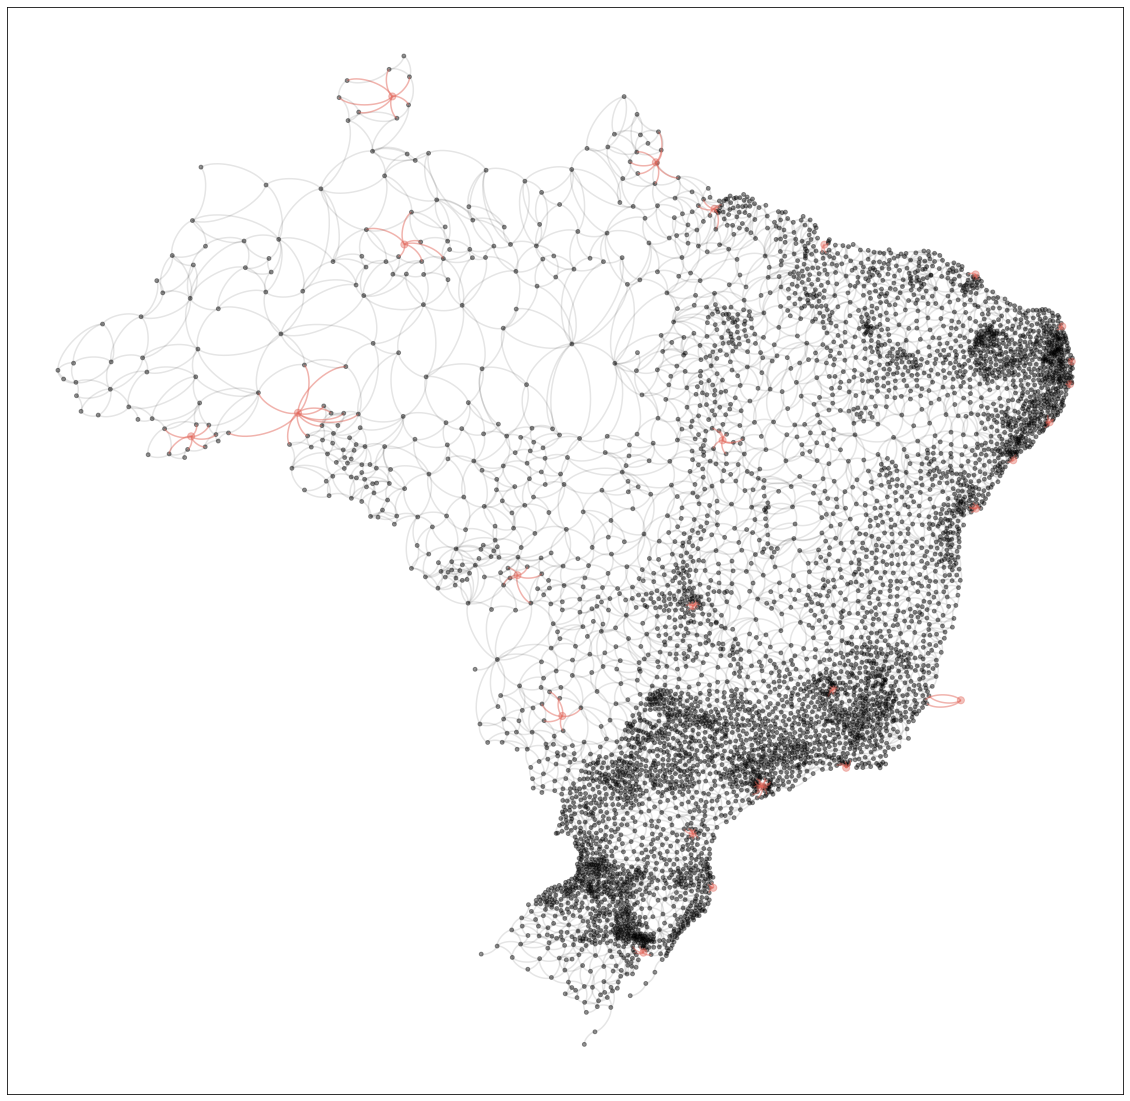

<Figure size 432x288 with 0 Axes>

In [188]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import networkx as nx
import numpy as np
import bezier

for node in G.nodes():
    long = G.nodes[node]["long"]
    lat = G.nodes[node]["lat"]
    loc = (long, lat)
    node_dict = {node: loc}
    nx.set_node_attributes(G, node_dict, "pos")


def curved_edges(G, pos, dist_ratio=0.2, bezier_precision=20, polarity="random"):
    # Get nodes into np array
    edges = np.array(G.edges())
    l = edges.shape[0]

    if polarity == "random":
        # Random polarity of curve
        rnd = np.where(np.random.randint(2, size=l) == 0, -1, 1)
    else:
        # Create a fixed (hashed) polarity column in the case we use fixed polarity
        # This is useful, e.g., for animations
        rnd = np.where(
            np.mod(np.vectorize(hash)(edges[:, 0]) + np.vectorize(hash)(edges[:, 1]), 2)
            == 0,
            -1,
            1,
        )

    # Coordinates (x,y) of both nodes for each edge
    # e.g., https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
    # Note the np.vectorize method doesn't work for all node position dictionaries for some reason
    u, inv = np.unique(edges, return_inverse=True)
    coords = np.array([pos[x] for x in u])[inv].reshape(
        [edges.shape[0], 2, edges.shape[1]]
    )
    coords_node1 = coords[:, 0, :]
    coords_node2 = coords[:, 1, :]

    # Swap node1/node2 allocations to make sure the directionality works correctly
    should_swap = coords_node1[:, 0] > coords_node2[:, 0]
    coords_node1[should_swap], coords_node2[should_swap] = (
        coords_node2[should_swap],
        coords_node1[should_swap],
    )

    # Distance for control points
    dist = dist_ratio * np.sqrt(np.sum((coords_node1 - coords_node2) ** 2, axis=1))

    # Gradients of line connecting node & perpendicular
    m1 = (coords_node2[:, 1] - coords_node1[:, 1]) / (
        coords_node2[:, 0] - coords_node1[:, 0]
    )
    m2 = -1 / m1

    # Temporary points along the line which connects two nodes
    # e.g., https://math.stackexchange.com/questions/656500/given-a-point-slope-and-a-distance-along-that-slope-easily-find-a-second-p
    t1 = dist / np.sqrt(1 + m1**2)
    v1 = np.array([np.ones(l), m1])
    coords_node1_displace = coords_node1 + (v1 * t1).T
    coords_node2_displace = coords_node2 - (v1 * t1).T

    # Control points, same distance but along perpendicular line
    # rnd gives the 'polarity' to determine which side of the line the curve should arc
    t2 = dist / np.sqrt(1 + m2**2)
    v2 = np.array([np.ones(len(edges)), m2])
    coords_node1_ctrl = coords_node1_displace + (rnd * v2 * t2).T
    coords_node2_ctrl = coords_node2_displace + (rnd * v2 * t2).T

    # Combine all these four (x,y) columns into a 'node matrix'
    node_matrix = np.array(
        [coords_node1, coords_node1_ctrl, coords_node2_ctrl, coords_node2]
    )

    # Create the Bezier curves and store them in a list
    curveplots = []
    for i in range(l):
        nodes = node_matrix[:, i, :].T
        curveplots.append(
            bezier.Curve(nodes, degree=2)
            .evaluate_multi(np.linspace(0, 1, bezier_precision))
            .T
        )

    # Return an array of these curves
    curves = np.array(curveplots)
    return curves


# Load the graph edges and compute the node positions using ForceAtlas2
# G = nx.read_edgelist('facebook_combined.txt')
positions = nx.get_node_attributes(G, "pos")
color_list = [
    (0.888292, 0.40830288, 0.36223756) if x[2]["capital"] == "sim" else "black"
    for x in list(G.edges(data=True))
]
alpha_list = [
    0.5 if x[2]["capital"] == "sim" else 0.1 for x in list(G.edges(data=True))
]
# Produce the curves
curves = curved_edges(G, positions)
lc = LineCollection(curves, color=color_list, alpha=alpha_list)


capital = nx.get_node_attributes(G, "capital")
size_list = [50 if x == "sim" else 15 for x in list(capital.values())]
alpha_list = [0.8 if x == "sim" else 0.4 for x in list(capital.values())]
color_list = [
    (0.888292, 0.40830288, 0.36223756) if x == "sim" else "black"
    for x in list(capital.values())
]
# size_norm = [float(i)/max(size_list) for i in size_list]

# Plot
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(
    G, positions, node_size=size_list, alpha=0.4, node_color=color_list
)
plt.gca().add_collection(lc)
plt.tick_params(
    axis="both",
    which="both",
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
plt.show()
plt.savefig("grafo_cidades.png", transparent=True)

<ipython-input-189-34ca75af7de7>:44: RuntimeWarning: invalid value encountered in true_divide
  m1 = (coords_node2[:,1]-coords_node1[:,1])/(coords_node2[:,0]-coords_node1[:,0])


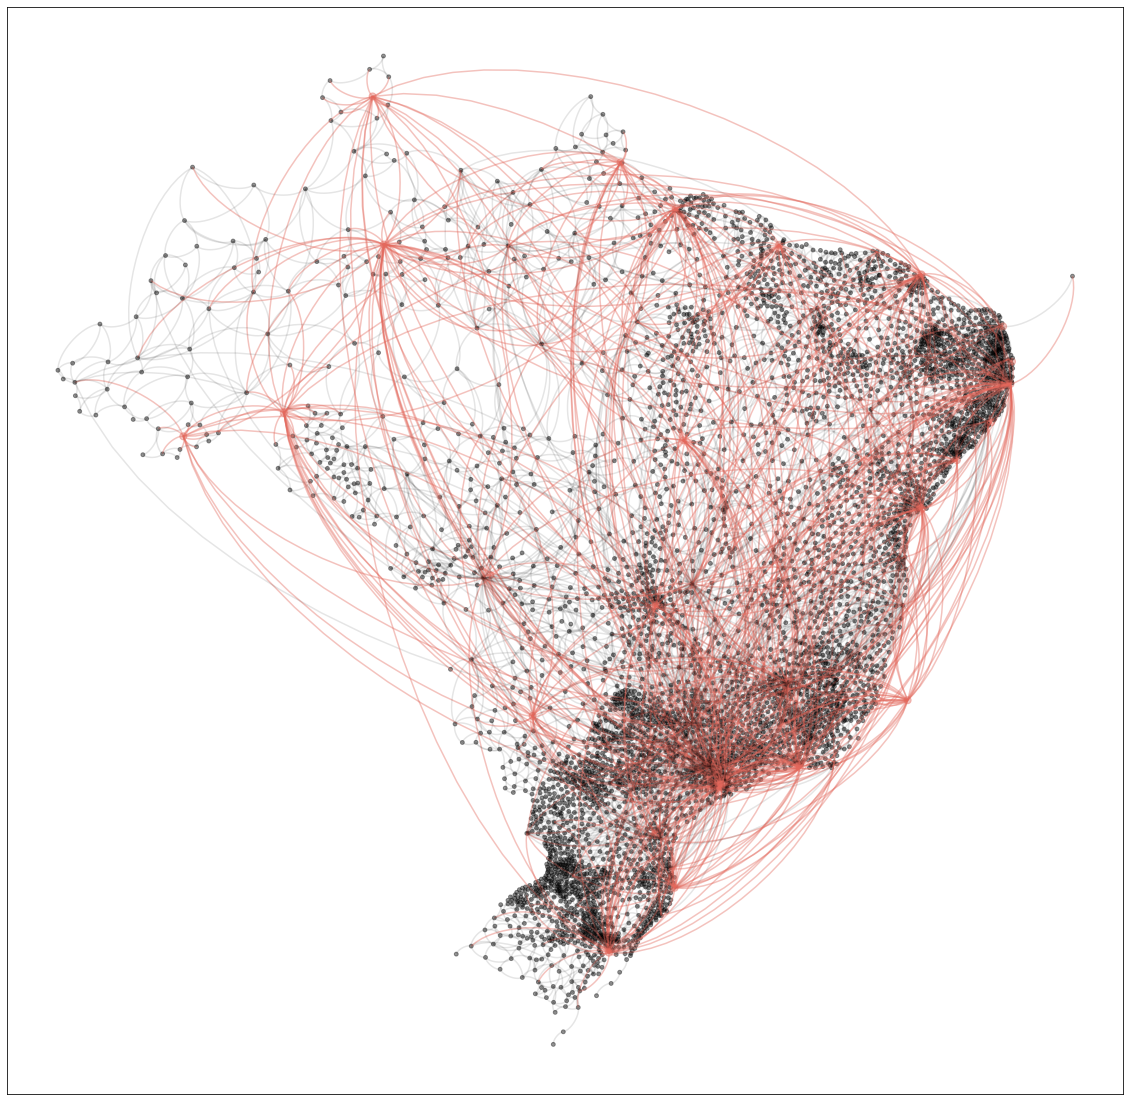

<Figure size 432x288 with 0 Axes>

In [189]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import networkx as nx
import numpy as np
import bezier

for node in H.nodes():
    long = H.nodes[node]["long"]
    lat = H.nodes[node]["lat"]
    loc = (long, lat)
    node_dict = {node: loc}
    nx.set_node_attributes(H, node_dict, "pos")


def curved_edges(G, pos, dist_ratio=0.2, bezier_precision=20, polarity="random"):
    # Get nodes into np array
    edges = np.array(G.edges())
    l = edges.shape[0]

    if polarity == "random":
        # Random polarity of curve
        rnd = np.where(np.random.randint(2, size=l) == 0, -1, 1)
    else:
        # Create a fixed (hashed) polarity column in the case we use fixed polarity
        # This is useful, e.g., for animations
        rnd = np.where(
            np.mod(np.vectorize(hash)(edges[:, 0]) + np.vectorize(hash)(edges[:, 1]), 2)
            == 0,
            -1,
            1,
        )

    # Coordinates (x,y) of both nodes for each edge
    # e.g., https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
    # Note the np.vectorize method doesn't work for all node position dictionaries for some reason
    u, inv = np.unique(edges, return_inverse=True)
    coords = np.array([pos[x] for x in u])[inv].reshape(
        [edges.shape[0], 2, edges.shape[1]]
    )
    coords_node1 = coords[:, 0, :]
    coords_node2 = coords[:, 1, :]

    # Swap node1/node2 allocations to make sure the directionality works correctly
    should_swap = coords_node1[:, 0] > coords_node2[:, 0]
    coords_node1[should_swap], coords_node2[should_swap] = (
        coords_node2[should_swap],
        coords_node1[should_swap],
    )

    # Distance for control points
    dist = dist_ratio * np.sqrt(np.sum((coords_node1 - coords_node2) ** 2, axis=1))

    # Gradients of line connecting node & perpendicular
    m1 = (coords_node2[:, 1] - coords_node1[:, 1]) / (
        coords_node2[:, 0] - coords_node1[:, 0]
    )
    m2 = -1 / m1

    # Temporary points along the line which connects two nodes
    # e.g., https://math.stackexchange.com/questions/656500/given-a-point-slope-and-a-distance-along-that-slope-easily-find-a-second-p
    t1 = dist / np.sqrt(1 + m1**2)
    v1 = np.array([np.ones(l), m1])
    coords_node1_displace = coords_node1 + (v1 * t1).T
    coords_node2_displace = coords_node2 - (v1 * t1).T

    # Control points, same distance but along perpendicular line
    # rnd gives the 'polarity' to determine which side of the line the curve should arc
    t2 = dist / np.sqrt(1 + m2**2)
    v2 = np.array([np.ones(len(edges)), m2])
    coords_node1_ctrl = coords_node1_displace + (rnd * v2 * t2).T
    coords_node2_ctrl = coords_node2_displace + (rnd * v2 * t2).T

    # Combine all these four (x,y) columns into a 'node matrix'
    node_matrix = np.array(
        [coords_node1, coords_node1_ctrl, coords_node2_ctrl, coords_node2]
    )

    # Create the Bezier curves and store them in a list
    curveplots = []
    for i in range(l):
        nodes = node_matrix[:, i, :].T
        curveplots.append(
            bezier.Curve(nodes, degree=2)
            .evaluate_multi(np.linspace(0, 1, bezier_precision))
            .T
        )

    # Return an array of these curves
    curves = np.array(curveplots)
    return curves


# Load the graph edges and compute the node positions using ForceAtlas2
# G = nx.read_edgelist('facebook_combined.txt')
positions = nx.get_node_attributes(H, "pos")
color_list = [
    (0.888292, 0.40830288, 0.36223756) if x[2]["capital"] == "sim" else "black"
    for x in list(H.edges(data=True))
]
alpha_list = [
    0.4 if x[2]["capital"] == "sim" else 0.1 for x in list(H.edges(data=True))
]
# Produce the curves
curves = curved_edges(H, positions)
lc = LineCollection(curves, color=color_list, alpha=alpha_list)

capital = nx.get_node_attributes(H, "capital")
size_list = [50 if x == "sim" else 15 for x in list(capital.values())]
alpha_list = [0.8 if x == "sim" else 0.4 for x in list(capital.values())]
color_list = [
    (0.888292, 0.40830288, 0.36223756) if x == "sim" else "black"
    for x in list(capital.values())
]
# size_norm = [float(i)/max(size_list) for i in size_list]

# Plot
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(
    H, positions, node_size=size_list, alpha=0.4, node_color=color_list
)
plt.gca().add_collection(lc)
plt.tick_params(
    axis="both",
    which="both",
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
plt.show()
plt.savefig("grafo_cidades_aeroportos.png", transparent=True)